<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Agentic_RAG_Real_Time_Agentic_AI_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install langchain langgraph langchain_groq langchain_huggingface

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
!pip install langchain_community

In [80]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from typing import Annotated, Literal,Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [81]:
from langchain_groq import ChatGroq
from google.colab import userdata
import os
os.environ['GROQ_API_KEY']=userdata.get('groq_api_key')
os.environ['HF_TOKEN']=userdata.get('HF_TOKEN')
llm = ChatGroq(model_name="Gemma2-9b-It")

In [82]:
!pip install duckduckgo-search

In [83]:
# use duckduck go
from langchain.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

In [84]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [85]:
llm.invoke("Hi?").content

'Hi! 👋\n\nHow can I help you today? 😊\n'

In [86]:
url="https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
data = loader.load()

In [87]:
data[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [88]:
data[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [89]:
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-06-15-prompt-engineering",
]

In [90]:
docs=[WebBaseLoader(url).load() for url in urls]

In [91]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [92]:
docs_list=[item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [93]:
!pip install tiktoken

In [94]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)

In [95]:
docs_splits=text_splitter.split_documents(docs_list)
docs_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [96]:
!pip install chromadb

In [97]:
vectorstore=Chroma.from_documents(
    documents=docs_splits,
    collection_name="rag-chrome",
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"),
)

retriever = vectorstore.as_retriever()

In [98]:
retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng's blog posts about LLM agents and Prompt Engineering",
)

In [99]:
tools=[retriever_tool]

In [100]:
retrieve=ToolNode([retriever_tool])

In [101]:
class AgentState(TypedDict):
  messages:Annotated[Sequence[BaseMessage],add_messages]

In [102]:
def ai_assistant(state: AgentState):
  print("--CALL AGENT---")
  messages=state['messages']
  llm_with_tools=llm.bind_tools(tools)
  response = llm_with_tools.invoke(messages)
  return {"messages":[response]}

In [103]:
class grade(BaseModel):
  binary_score:str=Field(description="Relevance score 'yes' or 'no'")


In [104]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)

    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant.
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [105]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [106]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content

    last_message = messages[-1]
    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")

    return {"messages": [response]}

In [107]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                    Here is the initial question: {question}
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [108]:
workflow=StateGraph(AgentState)
workflow.add_node("My_AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever",retrieve)
workflow.add_node("Output_Generator",generate)
workflow.add_node("Query_Rewrite",rewrite)

In [109]:
workflow.add_edge(START,"My_AI_Assistant")
workflow.add_conditional_edges(
    "My_AI_Assistant",
    tools_condition,
    {"tools":"Vector_Retriever", END: END,}
)

In [110]:
workflow.add_conditional_edges(
    "Vector_Retriever",
    grade_documents,
    {
    "generator":"Output_Generator",
    "rewriter":"Query_Rewrite",
    }
)

In [111]:
workflow.add_edge("Output_Generator",END)
workflow.add_edge("Query_Rewrite","My_AI_Assistant")

In [112]:
app=workflow.compile()

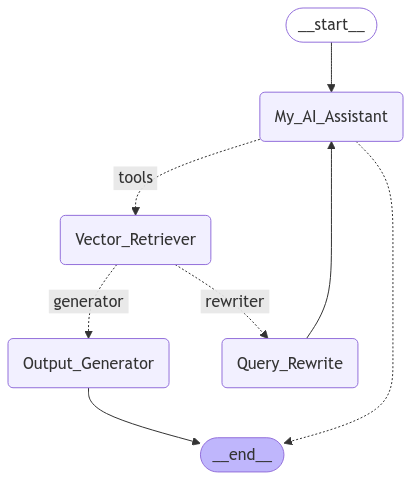

In [113]:
app

In [114]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

--CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response:content='An Autonomous Agent is a system, often built with a large language model (LLM) as its core, that can solve problems and perform tasks independently.  LLM-powered autonomous agents can be seen as powerful general problem solvers, going beyond simple text generation. Examples include AutoGPT, GPT-Engineer, and BabyAGI.  \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 390, 'total_tokens': 460, 'completion_time': 0.127272727, 'prompt_time': 0.012009644, 'queue_time': 0.021489095, 'total_time': 0.139282371}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-e01b68ef-709c-416d-b3da-6993f87ba5ec-0' usage_metadata={'input_tokens': 390, 'output_tokens': 70, 'total_tokens': 460}


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='513686b2-2765-4926-9bd1-f003010b92e1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5jk0', 'function': {'arguments': '{"query":"Autonomous Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 973, 'total_tokens': 1058, 'completion_time': 0.154545455, 'prompt_time': 0.031298781, 'queue_time': 0.023145487, 'total_time': 0.185844236}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e8efe54-47a8-4339-a438-66660e1fc804-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Autonomous Agent'}, 'id': 'call_5jk0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 973, 'output_tokens': 85, 'total_tokens': 1058}),
  ToolMessage(content='Search\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\

In [115]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

--CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
--CALL AGENT---


{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='9bd447f5-6707-458e-ad00-1703d5f46744'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j2pn', 'function': {'arguments': '{"query":"prompt engineering llm agents langchain"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 982, 'total_tokens': 1072, 'completion_time': 0.163636364, 'prompt_time': 0.039981888, 'queue_time': 0.021330572, 'total_time': 0.203618252}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d42a6ad-2ff3-4a1e-94ba-7a8e1b25ac22-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering llm agents langchain'}, 'id': 'call_j2pn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 982, 'output_tokens

In [116]:
app.invoke({"messages":["what is capital of india?"]})

--CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
--CALL AGENT---


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='0aea40a5-31cf-4848-87ca-9dad0d667c51'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bm1y', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 973, 'total_tokens': 1059, 'completion_time': 0.156363636, 'prompt_time': 0.031299531, 'queue_time': 0.022169939, 'total_time': 0.187663167}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ae8fdd1b-d253-4111-9526-9f2c7470ec58-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'capital of india'}, 'id': 'call_bm1y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 973, 'output_tokens': 86, 'total_tokens': 1059}),
  ToolMessage(content='format, where the following tokens must 